In [1]:
if 'google.colab' in str(get_ipython()):
      !git clone https://github.com/Loop3D/Kalgoorlie_fault_network.git
      %cd Kalgoorlie_fault_network/report_files
      !pip install git+https://github.com/Loop3D/LoopProjectFile.git
      !pip install git+https://github.com/Loop3D/map2loop-2.git
      !pip install git+https://github.com/Loop3D/LoopStructural
      !pip install lavavu-osmesa==1.8.32 geopandas meshio rasterio owslib

else:
      print('Not running on CoLab, nothing to do')

Not running on CoLab, nothing to do


In [2]:
#downloads the dem as a tif file from the WCS server

from owslib.wcs import WebCoverageService as w

wcs = w(url="http://services.ga.gov.au/site_9/services/DEM_SRTM_1Second_over_Bathymetry_Topography/MapServer/WCSServer?", 
        version = "1.0.0")

test = wcs.getCoverage(identifier = "1", bbox = (214793, 6501886, 400412, 6653022), 
                      format="GeoTIFF", crs = 28351, width=200, height=200)

file = open("./data/dem.tif", 'wb')
file.write(test.read())
file.close()

In [20]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from LoopStructural import GeologicalModel
from LoopStructural.visualisation import LavaVuModelViewer, RotationAnglePlotter
from LoopStructural.modelling import ProcessInputData
from LoopStructural.utils import dtm_creator

path_data = r"./data"
path_DEM = r"./data/dem.tif"

In [4]:
updated_data = pd.read_csv(os.path.join(path_data, "LoopStructural_data/updated_data.csv"))
updated_oris = pd.read_csv(os.path.join(path_data, "LoopStructural_data/updated_oris.csv"))

In [5]:
origin = [214794.5029269870719872, 6501887.2589999996125698, -40000]
maximum = [400411.4882275541312993, 6653021.2462467299774289, 5000]

In [6]:
# contacts
contacts = gpd.read_file(os.path.join(path_data, "./contacts/contacts_altitude.shp"))

contacts2 = pd.DataFrame({'X': contacts.geometry.x, 
                          'Y': contacts.geometry.y, 
                          'Z': contacts['dem_2'], 
                          'name': contacts['name']})

contacts2 = contacts2.dropna().reset_index()

In [7]:
# bedding measurements file

beddings = gpd.read_file(os.path.join(path_data, "./beddings/beddings_0001_altitude.shp"))

beddings2 = pd.DataFrame({'X': beddings.geometry.x, 
                          'Y': beddings.geometry.y, 
                          'Z': beddings['DEM_main'], 
                          'name': 'Feat_name', 
                          'strike': beddings['STRIKE'], 
                          'dip': beddings['DIP'], 
                          'polarity' : 1, ### should be 1
                         })

In [8]:
#thickness
thickness = {'Granitoids': 7000, 'Mafics': 3000, 'Black_Flag': 1500}

In [9]:
#strati_order

order = [
    ("Group_0", [ "Black_Flag", "Mafics", "Granitoids"]), 
]

In [10]:
processor = ProcessInputData(
    contacts=contacts2,
    contact_orientations=beddings2,
    thicknesses=thickness,
    stratigraphic_order=order,
    origin=origin,
    maximum=maximum, 
    fault_locations = updated_data, 
    fault_orientations = updated_oris
)

C:\Users\angel\anaconda3\envs\new_loop\Lib\site-packages\LoopStructural\modelling\input\process_data.py:315: RuntimeWarning: Mean of empty slice
  ] = np.nanmean(pts, axis=0)
                This will result in only a fault surface, no displacement on older features


In [12]:
# Add the fold
fold = gpd.read_file(os.path.join(path_data, "folds/folds.shp"))
fold['X'] = fold.geometry.x
fold['Y'] = fold.geometry.y

import math

strikes = []

for i in range(0, len(fold) - 1):
    x1, y1 = fold['X'][i], fold['Y'][i]
    x2, y2 = fold['X'][i + 1], fold['Y'][i + 1]
    strikes.append(math.degrees(math.atan2((x2 - x1), (y2 - y1))))

strikes.append(338 - 180)
fold['strikes'] = strikes

fold = pd.DataFrame({
    'X': fold['X'],
    'Y': fold['Y'],
    'Z': fold['dem'],
    'strike': fold['strikes'],
    'dip': fold['DIP']
})

from LoopStructural.utils import strike_dip_vector

fold_df = pd.DataFrame(strike_dip_vector(strike=fold['strike'] + 180,
                                      dip=fold['dip']),
                    columns=['nx', 'ny', 'nz'])

fold['nx'] = fold_df['nx']
fold['ny'] = fold_df['ny']
fold['nz'] = fold_df['nz']

fold['feature_name'] = 's1'
fold['val'] = 0
fold['coord'] = 0
fold['val'].loc[10] = 1

C:\Users\angel\AppData\Local\Temp\ipykernel_27328\181228415.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fold['val'].loc[10] = 1


In [13]:
data_test = pd.concat([processor.data, fold])

In [14]:
# patches
# 1. find empty feature name in the data_test
data_test['feature_name'] = data_test['feature_name'].fillna('Group_0')

# 2. find zs that are empty
data_test['Z'] = data_test['Z'].fillna(380)

In [15]:
mx = fold['X'].mean()
my = fold['Y'].mean()
mz = fold['Z'].mean()

a = pd.DataFrame(pd.Series({'X': mx, 
             'Y': my, 
             'Z': mz, 
            'feature_name': 's1',
             'val':1,
             'coord':1})).T

In [16]:
data_test = pd.concat([data_test, a])

In [26]:
model = GeologicalModel(origin = origin, maximum=maximum)
model.data = data_test

model.stratigraphic_column = processor.stratigraphic_column

# model.dtm = dtm_creator.create_dtm_with_rasterio(path_DEM) 

S1 = model.create_and_add_fold_frame('s1',
                                     nelements=1e4, 
                                     buffer=0.3,
                                     damp=True)

fold_weights = {'fold_orientation': 0.5, 
                'fold_axis_w': 0.5, 
                'fold_regularisation': [0.0, 0.0, 0.], 
                'fold_normalisation': 0.25, 
                'fold_norm': 0.25, 
                'step': 150}

S0 = model.create_and_add_folded_foliation('Group_0',
                                            limb_wl= 20000, 
                                            fold_frame=S1,
                                           fold_weights = fold_weights,
                                            av_fold_axis=False,
                                            nelements=1e4,
                                            buffer = 0.5, 
                                            solver='lu', 
                                           )
model.update()

ERROR: 2023-03-21 09:43:58,807: _base_geological_feature.py:73 -- Model not set
ERROR: 2023-03-21 09:43:58,809: _base_geological_feature.py:73 -- Model not set
ERROR: 2023-03-21 09:43:58,809: _base_geological_feature.py:73 -- Model not set


Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region
Cannot use region


  0%|          | 0/4 [00:00<?, ?it/s]

ERROR: 2023-03-21 09:44:02,998: _geological_feature_builder.py:213 -- Not enough constraints for scalar field add more
C:\Users\angel\anaconda3\envs\new_loop\Lib\site-packages\LoopStructural\modelling\features\fold\_fold.py:98: RuntimeWarning: invalid value encountered in divide
  dgx[mask, :] /= np.linalg.norm(dgx[mask, :], axis=1)[:, None]


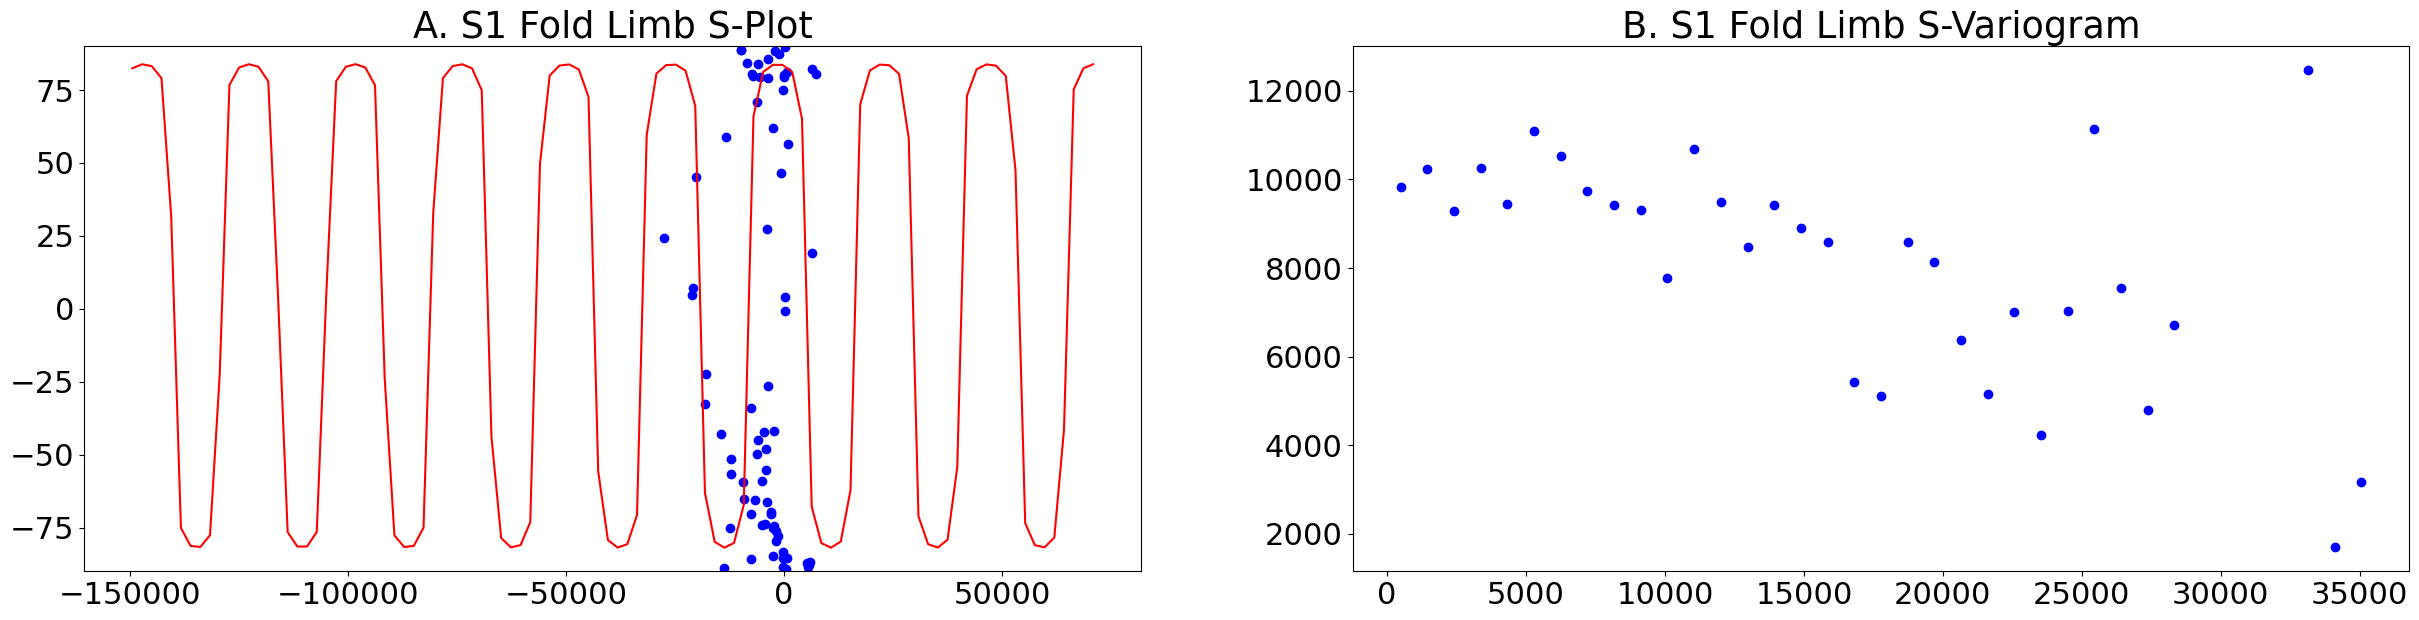

In [27]:
plt.rcParams.update({'font.size': 22})
S0.fold.foldframe[0].set_model(model)

S1_S0_splot = RotationAnglePlotter(S0)
S1_S0_splot.add_fold_limb_data()
S1_S0_splot.add_fold_limb_curve() 
S1_S0_splot.add_limb_svariogram()#fold_limb_
S1_S0_splot.ax[1,0].set_title('A. S1 Fold Limb S-Plot')
S1_S0_splot.ax[1,1].set_title('B. S1 Fold Limb S-Variogram')

S1_S0_splot.fig.delaxes(S1_S0_splot.ax[0][0])
S1_S0_splot.fig.delaxes(S1_S0_splot.ax[0][1])

[-149476.36060755 -146171.3260587  -142866.85406448 ...   68370.97402747
   69525.21954289   70675.45418944]



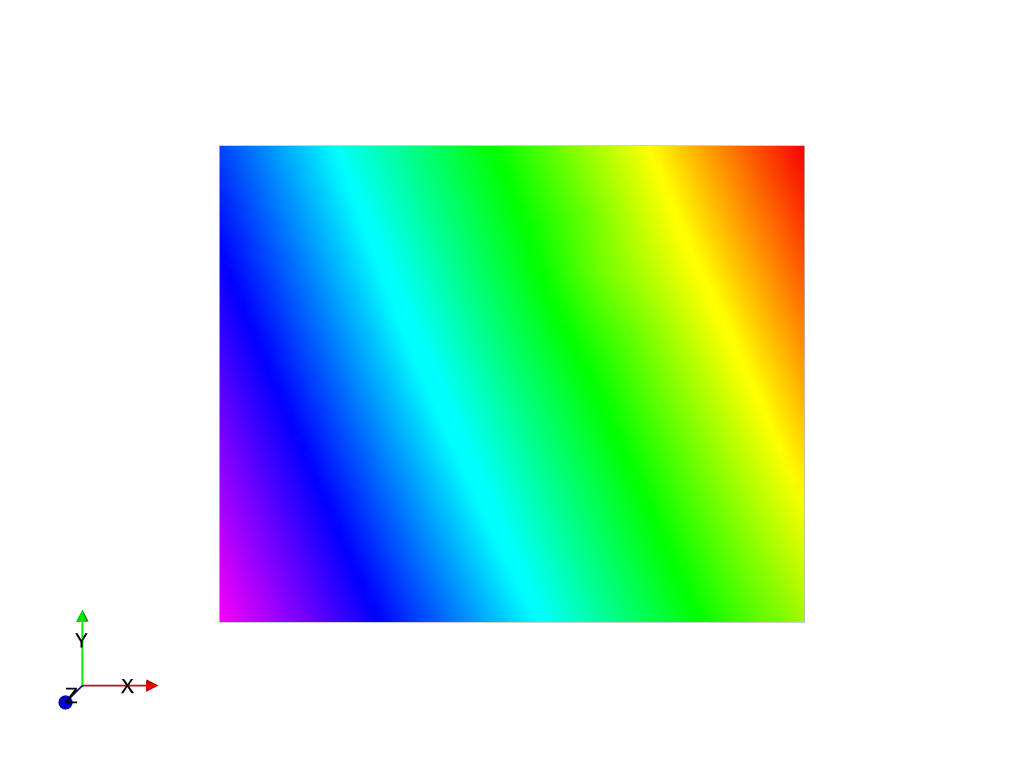

In [28]:
view = LavaVuModelViewer(model)
view.add_scalar_field(S1[0])
view.display()

[0.75728499 0.74956244 0.74180023 ... 1.08132888 1.09708235 1.11273974]



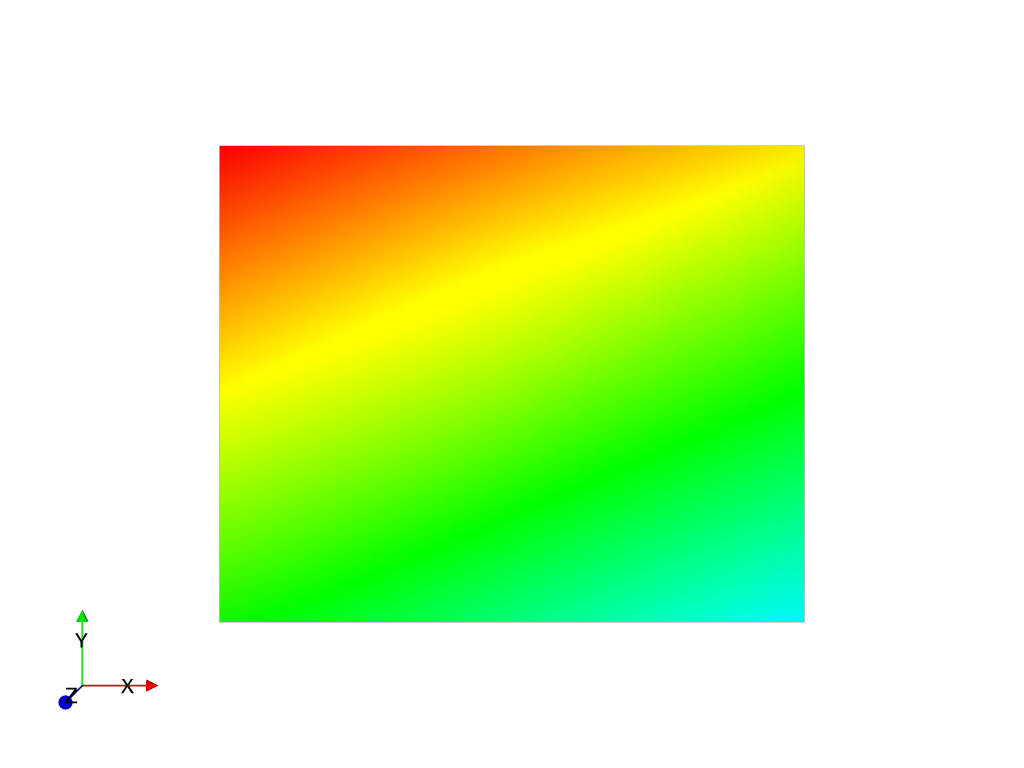

In [29]:
view = LavaVuModelViewer(model)
view.add_scalar_field(S1[1])
view.display()


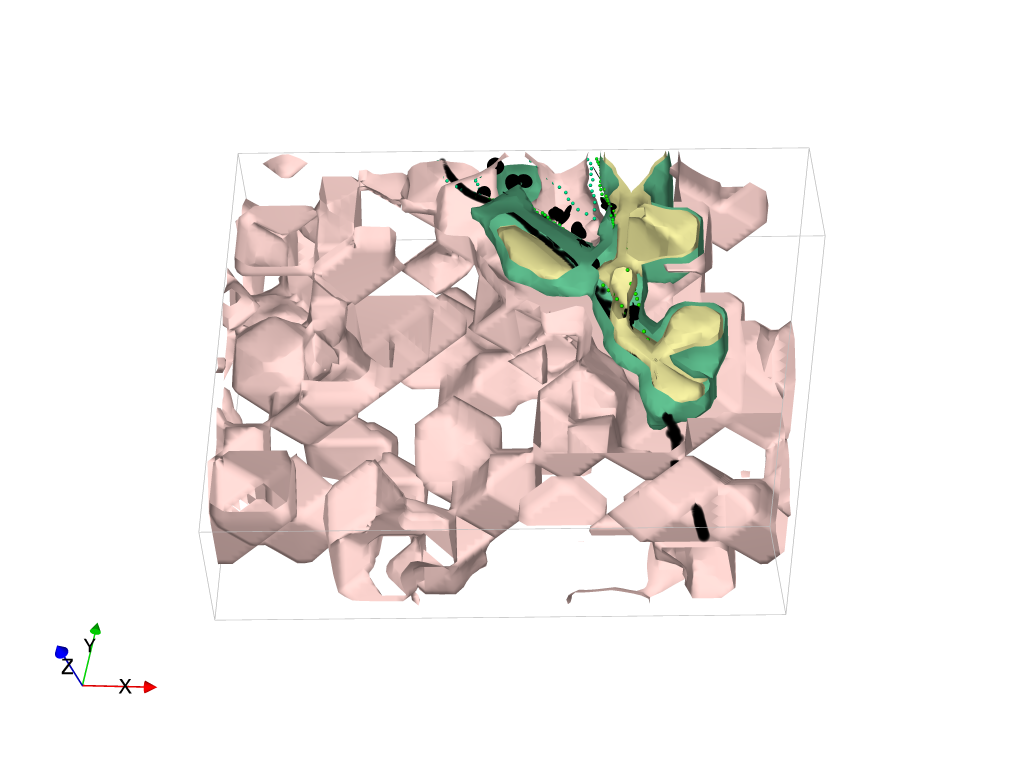

In [32]:
view = LavaVuModelViewer(model)

view.nelements = 1e5
all_names = []
all_values = []
colores = [['#ffd6d1'], ['#5ebc8d'], ['#ece79b']]

for n, vals in model.stratigraphic_column['Group_0'].items():
    all_names.append(n)
    all_values.append(vals['min'])
    
for i, valuey in enumerate(all_values):
    view.add_isosurface(model['Group_0'], value = valuey, 
                        colours = colores[i], 
                        names = [all_names[i]])

view.add_points(updated_data[updated_data['fault_name']=='Zuleika Fault'][['X', 'Y', 'Z']], name='Zuleika', pointsize = 10)
view.add_data(model['Group_0'])
view.rotation = [-39.08073043823242, -8.032228469848633, 0.557145893573761]
view.display()